In [2]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import csv
import random

### Load data and define the dataset name

In [3]:
Bot = pd.read_csv('GAN_generation/Bot_Attack_Data_for_GAN.csv', sep=',')
Bot.name = 'Bot'
print(Bot.shape)


BF_SSH_Patator = pd.read_csv('GAN_generation/Brute_Force_SSH_Patator_Data.csv', sep=',')
BF_SSH_Patator.name = 'BF_SSH_Patator'
print(BF_SSH_Patator.shape)

BF_FTP_Patator = pd.read_csv('GAN_generation/Brute_Force_FTP_Patator_Data.csv', sep=',')
BF_FTP_Patator.name = 'BF_FTP_Patator'
print(BF_FTP_Patator.shape)


WA_Brute_Force = pd.read_csv('GAN_generation/Web_Attack_Brute_Force_Data.csv', sep=',')
WA_Brute_Force.name = 'WA_Brute_Force'
print(WA_Brute_Force.shape)

WA_XSS = pd.read_csv('GAN_generation/Web_Attack_XSS_Data.csv', sep=',')
WA_XSS.name = 'WA_XSS'
print(WA_XSS.shape)


DoS_GoldenEye = pd.read_csv('GAN_generation/Dos_GoldenEye_Data.csv', sep=',')
DoS_GoldenEye.name = 'DoS_GoldenEye'
print(DoS_GoldenEye.shape)

DoS_Hulk = pd.read_csv('GAN_generation/DoS_Hulk_Data.csv', sep=',')
DoS_Hulk.name = 'DoS_Hulk'
print(DoS_Hulk.shape)

DoS_Slowhttptest = pd.read_csv('GAN_generation/DoS_Slowhttptest_Data.csv', sep=',')
DoS_Slowhttptest.name = 'DoS_Slowhttptest'
print(DoS_Slowhttptest.shape)

DoS_Slowlori = pd.read_csv('GAN_generation/DoS_Slowlori_Data.csv', sep=',')
DoS_Slowlori.name = 'DoS_Slowlori'
print(DoS_Slowlori.shape)

(1361, 24)
(5895, 25)
(7931, 25)
(1507, 25)
(652, 25)
(10288, 24)
(216885, 24)
(5499, 24)
(5769, 24)


### Amount of data needed to generate for each label

In [4]:
Bot_generate = 83316

BF_SSH_Patator_generate = 181899

BF_FTP_Patator_generate = 180881

WA_Brute_Force_generate = 71153

WA_XSS_generate = 71581

DoS_GoldenEye_generate = 187210

DoS_Hulk_generate = 83911

DoS_Slowhttptest_generate = 189604

DoS_Slowlori_generate = 189469

### Model Inputs

In [5]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")

    return inputs_real, inputs_z

### Generator

In [6]:
def generator(z, out_dim, n_units=64, reuse=False,  alpha=0.01):
  
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        
        #ReLU
        h1 = tf.maximum(0.0, h1)
        
        # Logits and sigmoid output
        logits = tf.layers.dense(h1, out_dim, activation=None)
    
        out = tf.nn.sigmoid(logits)

        return out, logits

### Discriminator

In [7]:
def discriminator(x, n_units=64, reuse=False, alpha=0.01):

    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        
        # Logits and sigmoid output
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.nn.sigmoid(logits)

        return out, logits

### Hyperparameters 

In [8]:
# Select the dataset to use
DATASET = Bot

# Network Hyperparameters
INPUT_SIZE = len(DATASET.columns)
# Size of latent vector to generator
Z_SIZE = 70 
G_HIDDEN_SIZE = 64
D_HIDDEN_SIZE = 64
ALPHA = 0.02
SMOOTH = 0.1

# Training parameters
BATCH_SIZE=100 
EPOCHS = 101
AMOUNT_TO_GENERATE = Bot_generate 

### Building the Network

In [9]:
tf.reset_default_graph()
# Create the input placeholders
input_real, input_z = model_inputs(INPUT_SIZE, Z_SIZE)

# Generator network
g_model, g_logits = generator(input_z, INPUT_SIZE, G_HIDDEN_SIZE, reuse=False,  alpha=ALPHA)

# Discriminator network
d_model_real, d_logits_real = discriminator(input_real, D_HIDDEN_SIZE, reuse=False, alpha=ALPHA)
d_model_fake, d_logits_fake = discriminator(g_model, D_HIDDEN_SIZE, reuse=True, alpha=ALPHA)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


### Training losses

In [10]:
d_labels_real = tf.ones_like(d_logits_real) * (1 - SMOOTH)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_logits_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_logits_fake)

d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_fake),
        logits=d_logits_fake))

### Optimizer

In [11]:
# Split the trainable_variables into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

# Optimizer
d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

### Training

In [12]:
# Select the dataset to train
index = DATASET.index
number_of_rows = len(index)

samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(EPOCHS):
        for ii in range(number_of_rows//BATCH_SIZE):

            data = DATASET.sample(BATCH_SIZE) 
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, Z_SIZE))

            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: data, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})

        # At each 100 epochs, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: data})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        if e%100 == 0:
            print("Epoch {}/{}...".format(e+1, EPOCHS),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))

        if e==(EPOCHS-1):
            # Sample from generator as we're training for viewing afterwards
            sample_z = np.random.uniform(-1, 1, size=(AMOUNT_TO_GENERATE, Z_SIZE))
            gen_samples = sess.run(
                           generator(input_z, INPUT_SIZE, reuse=True),
                           feed_dict={input_z: sample_z})
            samples.append(gen_samples)
            saver.save(sess, './checkpoints/generator.ckpt')

Epoch 1/101... Discriminator Loss: 1.1004... Generator Loss: 0.9121
Epoch 101/101... Discriminator Loss: 1.2455... Generator Loss: 0.9133


### Losses graphic

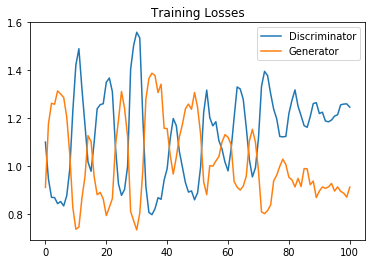

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Save the generated data to a csv file 

In [43]:
samples[0] #= (out, logists)
output, generated_data = samples[0]
generated_data.shape

file_name = "GAN_generation/GAN_Generated_Data/Standard_GAN_generated_"+DATASET.name+".csv"

# Save training generator samples
np.savetxt(file_name,output,delimiter=",")